### Dependencies

In [1]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from network import AttNet   

c:\Users\Clare\anaconda3\envs\tf2\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [8]:
def load_checkpoint():
    # Initialize the model
    model = AttNet(use_an=True)
    
    # Load the latest checkpoint
    ckpt = tf.train.Checkpoint(model=model)
    status = ckpt.restore(tf.train.latest_checkpoint("Checkpoint(5000epoch,lr=1e-4)/checkpoints"))
    status.expect_partial()  # Silences the warnings
    
    return model

def get_encoded_prompts(src_image_name, ref_image_name):
    # Load prompts
    input_prompts_df = pd.read_csv("raw_encoded_test.csv")
    reference_prompts_df = pd.read_csv("expert_encoded_test.csv")

    # Create dictionaries for quick lookup
    input_prompts_dict = dict(zip(input_prompts_df['image'], input_prompts_df['encoded_prompt'].apply(eval)))
    reference_prompts_dict = dict(zip(reference_prompts_df['image'], reference_prompts_df['encoded_prompt'].apply(eval)))

    # Get the corresponding prompts
    input_prompt = input_prompts_dict[src_image_name]
    reference_prompt = reference_prompts_dict[ref_image_name]
    
    return input_prompt, reference_prompt

In [9]:
def predict_output(model, src_image_path, ref_image_path, input_prompt, reference_prompt):
    # Load and resize images
    img_src = np.array(Image.open(src_image_path).resize((256, 256)))
    img_ref = np.array(Image.open(ref_image_path).resize((256, 256)))

    # Normalize images to [-1, 1]
    img_src_normed = (img_src.astype(np.float32) / 127.5) - 1
    img_ref_normed = (img_ref.astype(np.float32) / 127.5) - 1

    # Convert images to tensors and add batch dimension
    src_tensor = tf.expand_dims(img_src_normed, axis=0)
    ref_tensor = tf.expand_dims(img_ref_normed, axis=0)

    # Convert prompts to tensors
    input_prompt_tensor = tf.expand_dims(tf.convert_to_tensor(input_prompt, dtype=tf.float32), axis=0)
    reference_prompt_tensor = tf.expand_dims(tf.convert_to_tensor(reference_prompt, dtype=tf.float32), axis=0)

    # Perform inference
    out_tensor = model(src_tensor, ref_tensor, input_prompts=input_prompt_tensor, reference_prompts=reference_prompt_tensor, alpha=1.0)
    img_out = out_tensor.numpy()[0]
    img_out = (img_out + 1) * 127.5
    img_out = img_out.astype(np.uint8)

    return img_out

In [10]:
# Load the model from checkpoint
model = load_checkpoint()

# Specify source and reference images
src_image_name = "a4656-DSC_0232.jpg"
ref_image_name = "a4667-DSC_0480.jpg"

# Get encoded prompts for the specified images
input_prompt, reference_prompt = get_encoded_prompts(src_image_name, ref_image_name)

# Predict the output image
src_image_path = f"Image(Expert_E_256)/raw_test/{src_image_name}"
ref_image_path = f"Image(Expert_E_256)/raw_test/{ref_image_name}"
output_image = predict_output(model, src_image_path, ref_image_path, input_prompt, reference_prompt)

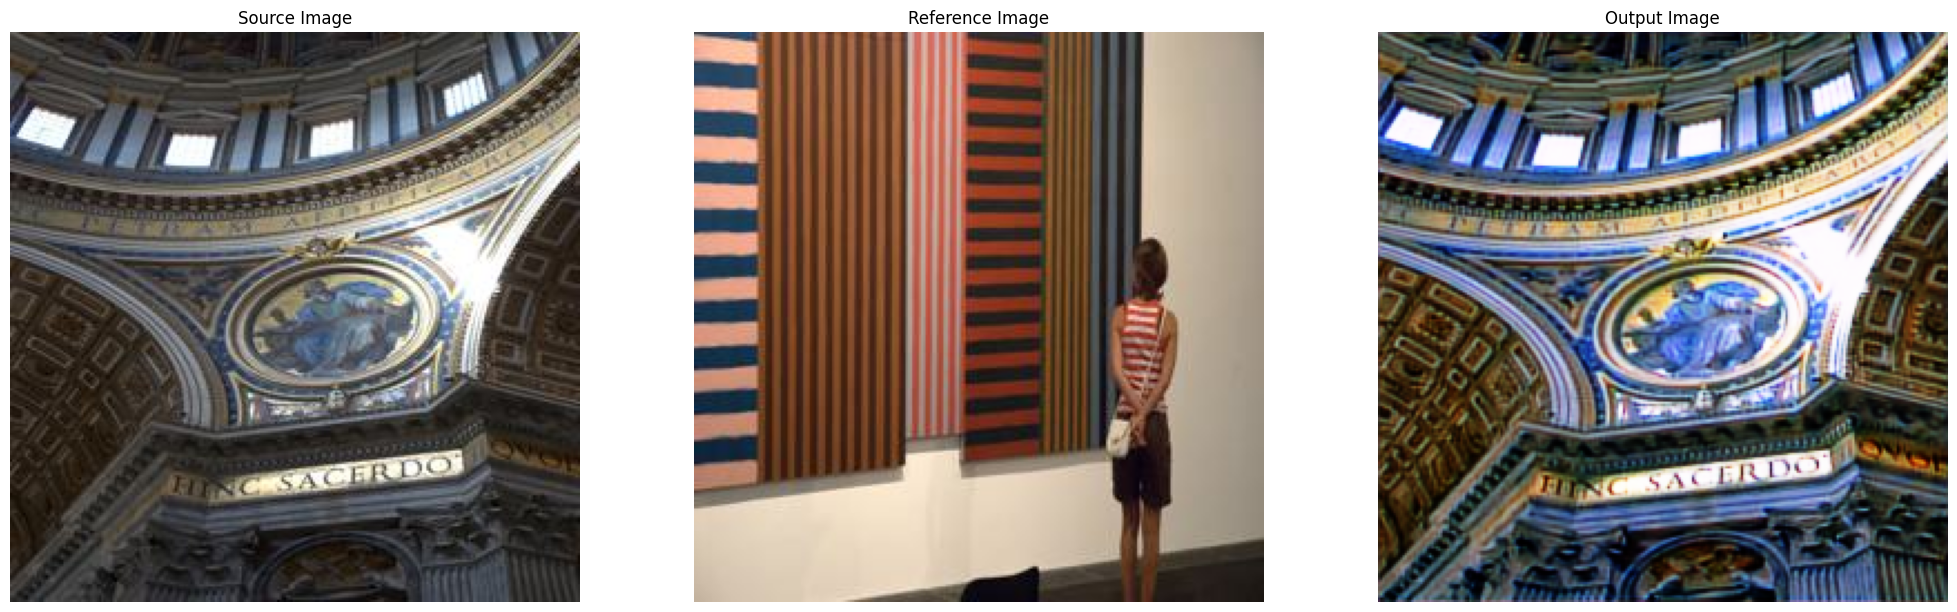

In [11]:
# Display the images
plt.figure(figsize=(25, 25))

plt.subplot(1, 3, 1)
plt.title('Source Image')
plt.imshow(Image.open(src_image_path))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Reference Image')
plt.imshow(Image.open(ref_image_path))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Output Image')
plt.imshow(output_image)
plt.axis('off')

plt.show()